## Assignment

In this assignment, you'll continue working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on several facets of education on an annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. 

Access this data using the Thinkful database using these credentials:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'useducation'<br>

Don't forget to apply the most suitable missing value filling techniques from the previous checkpoint to the data. Provide the answers to the following only *after* you've addressed missing values!

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Consider the two variables: *TOTAL_REVENUE* and *TOTAL_EXPENDITURE*. Do these variables have outlier values?
2. If you detect outliers in the *TOTAL_REVENUE* and *TOTAL_EXPENDITURE* variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.
3. Create another variable by subtracting the original *TOTAL_EXPENDITURE* from *TOTAL_REVENUE* (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.
4. Now create another variable by subtracting the *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. This time, use the outlier eliminated versions of *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. In this newly created variable, can you find any outliers? If so, eliminate them.
5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?
6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
%matplotlib inline

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation', con=engine)

engine.dispose()

In [3]:
unique_states = list(df.STATE.unique())

In [4]:
appended_data = []

for state in unique_states:
    state_df = df[df.STATE == state].copy().sort_values('YEAR').interpolate(limit_direction='both')
    appended_data.append(state_df)

filled_df = pd.concat(appended_data)

In [5]:
filled_df.dropna(thresh=12, inplace=True) 

In [6]:
filled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1490
Data columns (total 25 columns):
PRIMARY_KEY                     1331 non-null object
STATE                           1331 non-null object
YEAR                            1331 non-null int64
ENROLL                          1331 non-null float64
TOTAL_REVENUE                   1331 non-null float64
FEDERAL_REVENUE                 1331 non-null float64
STATE_REVENUE                   1331 non-null float64
LOCAL_REVENUE                   1331 non-null float64
TOTAL_EXPENDITURE               1331 non-null float64
INSTRUCTION_EXPENDITURE         1331 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1331 non-null float64
OTHER_EXPENDITURE               1331 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1331 non-null float64
GRADES_PK_G                     1331 non-null float64
GRADES_KG_G                     1331 non-null float64
GRADES_4_G                      1331 non-null float64
GRADES_8_G                      1

Data lightly cleaned and linearly interpolated by year and state, rows with a large number of null values after interpolation have been removed.

### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

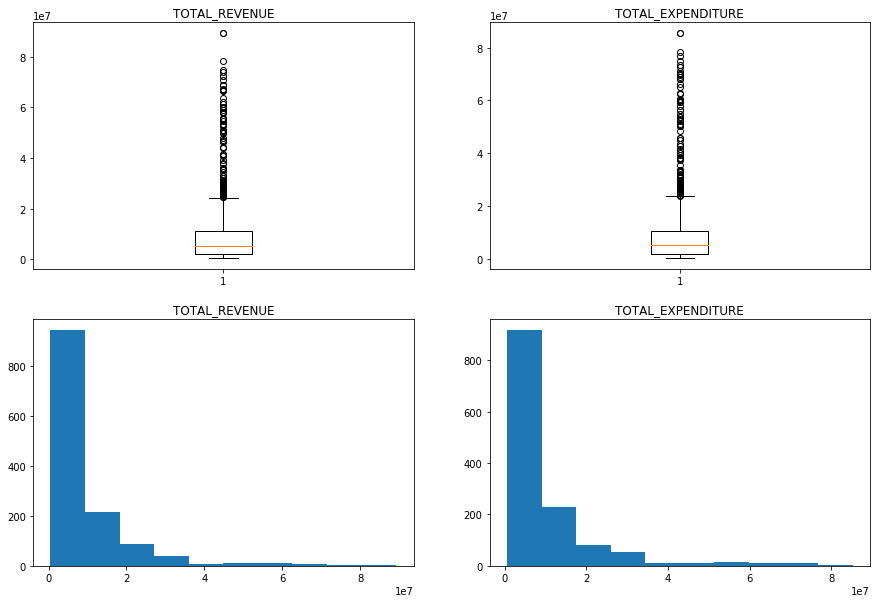

In [7]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(221)
plt.boxplot(filled_df.TOTAL_REVENUE)
plt.title('TOTAL_REVENUE')
fig.add_subplot(222)
plt.boxplot(filled_df.TOTAL_EXPENDITURE)
plt.title('TOTAL_EXPENDITURE')
fig.add_subplot(223)
plt.hist(filled_df.TOTAL_REVENUE)
plt.title('TOTAL_REVENUE')
fig.add_subplot(224)
plt.hist(filled_df.TOTAL_EXPENDITURE)
plt.title('TOTAL_EXPENDITURE')
plt.show()

Based on a visual analysis it would appear we do indeed have a number of upper outliers if our threshold was the default (1.5) IQR range. What about using a statistical analysis?

In [8]:
rev_zscores = zscore(filled_df.TOTAL_REVENUE)
exp_zscores = zscore(filled_df.TOTAL_EXPENDITURE)

In [9]:
def outlier_count(series, threshold):
    print('Threshold:', threshold)
    print('Number of outliers:', len(np.where(series > threshold)[0]))
    print('Percent of data that is outlier:', len(np.where(series > threshold)[0])/len(series)*100)

Check when the threshold is 1...

In [10]:
outlier_count(rev_zscores, 1)

Threshold: 1
Number of outliers: 139
Percent of data that is outlier: 10.443275732531932


In [11]:
outlier_count(exp_zscores, 1)

Threshold: 1
Number of outliers: 139
Percent of data that is outlier: 10.443275732531932


If our threshold is 1 standard deviation with the z score method - then there are 139 outliers for both series of data - this may be a bit extreme as 10 percent of the data turn out to be outliers.

In [12]:
outlier_count(rev_zscores, 2)
outlier_count(exp_zscores, 2)

Threshold: 2
Number of outliers: 53
Percent of data that is outlier: 3.9819684447783623
Threshold: 2
Number of outliers: 54
Percent of data that is outlier: 4.0570999248685204


In [13]:
outlier_count(rev_zscores, 1.5)
outlier_count(exp_zscores, 1.5)

Threshold: 1.5
Number of outliers: 88
Percent of data that is outlier: 6.6115702479338845
Threshold: 1.5
Number of outliers: 91
Percent of data that is outlier: 6.836964688204357


Somewhere in this range seems more reasonable as it lies closer to the 95% of all the data are not outliers range - winsorizing may be the best method here.

### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

#### Winsorizing

In [14]:
wins_rev = winsorize(filled_df.TOTAL_REVENUE, (0, .1))
wins_exp = winsorize(filled_df.TOTAL_EXPENDITURE, (0, .1))

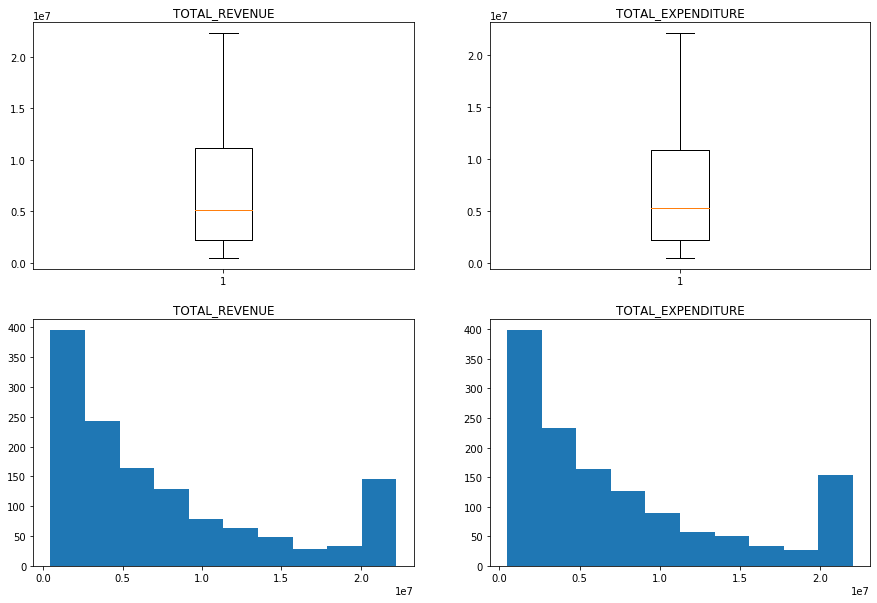

In [15]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(221)
plt.boxplot(wins_rev)
plt.title('TOTAL_REVENUE')
fig.add_subplot(222)
plt.boxplot(wins_exp)
plt.title('TOTAL_EXPENDITURE')
fig.add_subplot(223)
plt.hist(wins_rev)
plt.title('TOTAL_REVENUE')
fig.add_subplot(224)
plt.hist(wins_exp)
plt.title('TOTAL_EXPENDITURE')
plt.show()

Potential problem - definite skew for the higher end of the data (as expected when winsorizing this way) - maybe log transformation would work better?
Potential advantage - no need to transform data!

#### Log Transformation

In [16]:
log_rev = np.log(filled_df.TOTAL_REVENUE)
log_exp = np.log(filled_df.TOTAL_EXPENDITURE)

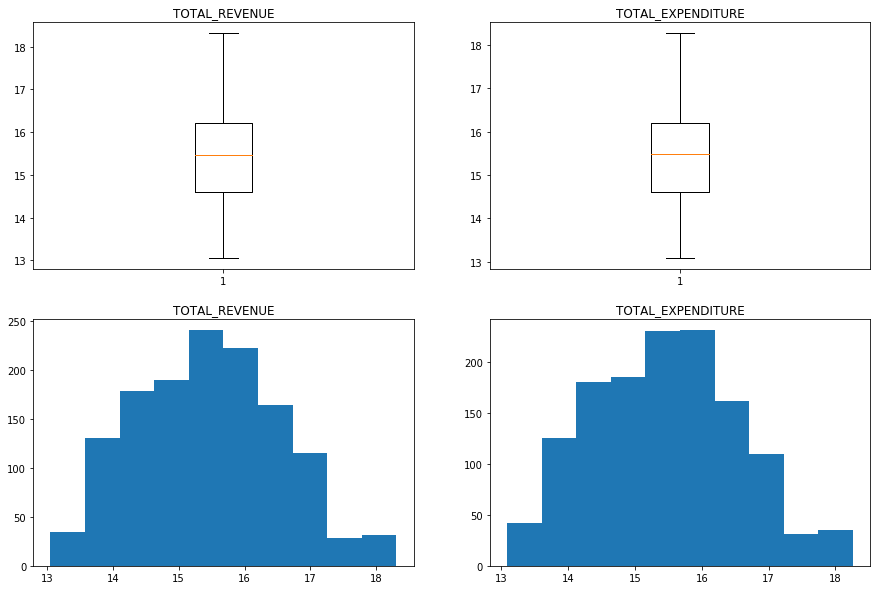

In [17]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(221)
plt.boxplot(log_rev)
plt.title('TOTAL_REVENUE')
fig.add_subplot(222)
plt.boxplot(log_exp)
plt.title('TOTAL_EXPENDITURE')
fig.add_subplot(223)
plt.hist(log_rev)
plt.title('TOTAL_REVENUE')
fig.add_subplot(224)
plt.hist(log_exp)
plt.title('TOTAL_EXPENDITURE')
plt.show()

Potential advantage - this log based data gives us approximately normal data, which is nice!\
Potential disadvantage - transforming.

### 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [18]:
filled_df['DEFICIT_SURPLUS'] = filled_df.TOTAL_REVENUE - filled_df.TOTAL_EXPENDITURE

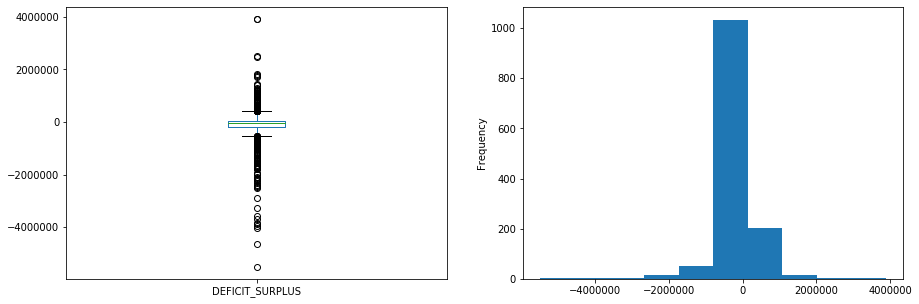

In [19]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
filled_df.DEFICIT_SURPLUS.plot(kind='box')
fig.add_subplot(122)
filled_df.DEFICIT_SURPLUS.plot(kind='hist')
plt.show()

There are a massive amount of outliers using the IQR/Tukey method displayed by the boxplot above. Can't do a straight up log transformation here since we have a multitude of negative numbers. So let's do a transformation with a constant, then take the log.

In [20]:
transform_constant = abs(filled_df.DEFICIT_SURPLUS.min() - .000001) ####log of zero is undefined so very slight amount added
trans_def = filled_df.DEFICIT_SURPLUS + transform_constant
log_def = np.log(trans_def)

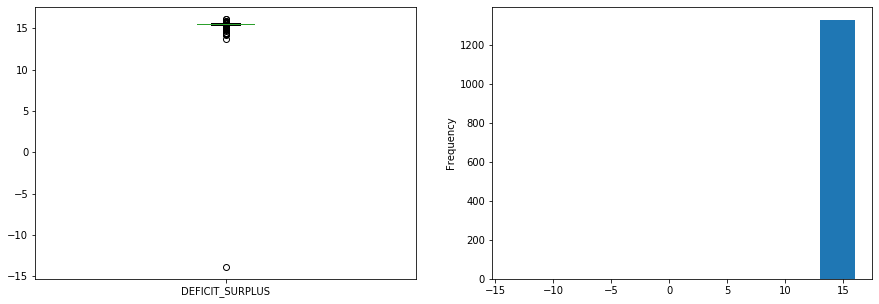

In [21]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
log_def.plot(kind='box')
fig.add_subplot(122)
log_def.plot(kind='hist')
plt.show()

Well...that didn't really work very well - winsorizing away!

In [22]:
wins_def = winsorize(filled_df.DEFICIT_SURPLUS, (.1, .1))
wins_def

masked_array(data=[  25087.,   -6042., -133043., ...,   83699.,  -90069.,
                    -90069.],
             mask=False,
       fill_value=1e+20)

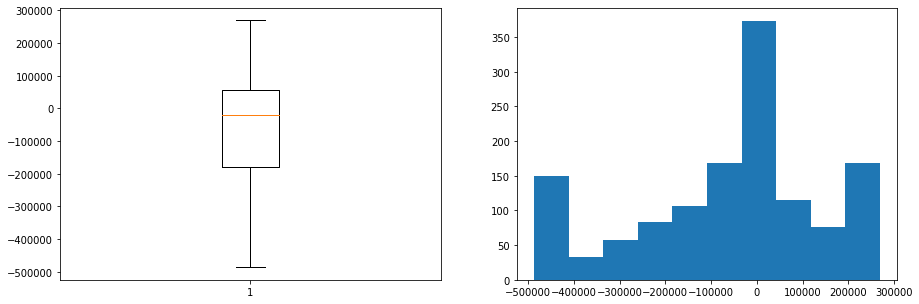

In [23]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.boxplot(wins_def)
fig.add_subplot(122)
plt.hist(wins_def)
plt.show()

This looks more reasonable - limiting to between the 10th and 90th percentile of values appears to have removed all outliers.

### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [24]:
wins_sub_def = wins_rev - wins_exp

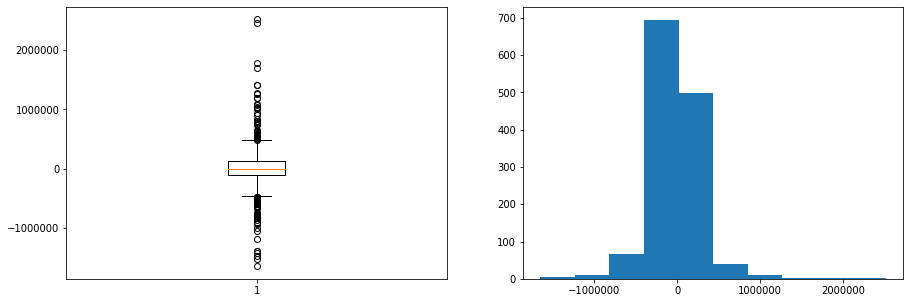

In [25]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.boxplot(wins_sub_def)
fig.add_subplot(122)
plt.hist(wins_sub_def)
plt.show()

Initially this looks a lot like the original less the original, only with less extreme values (but we still have extreme values). Let's winsorize our subtracted winsorized data.

In [26]:
wins_wins_def = winsorize(wins_sub_def, (.05, .05))

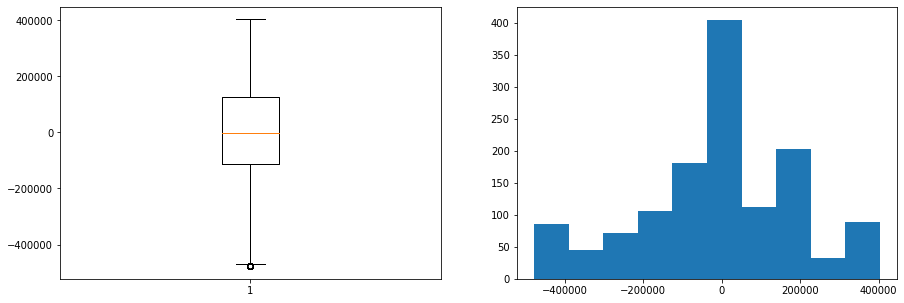

In [27]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.boxplot(wins_wins_def)
fig.add_subplot(122)
plt.hist(wins_wins_def)
plt.show()

This data is winsorized between the 5th and 95th percentile and only appears to have one outlier with the boxplot visualization - I could bring it in further, but the initial difference was already winsorized to an extent, so no need to over eliminate outliers.

### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [28]:
def describe(array):
    print('Mean:', array.mean())
    print('Median:', np.median(array))
    print('Std:', array.std())
    print('Var:', array.var())

In [35]:
describe(wins_def)

Mean: -60852.062359128475
Median: -19755.0
Std: 214285.2710908398
Var: 45918177406.4747


In [30]:
describe(wins_wins_def)

Mean: -8983.38241923366
Median: -1524.0
Std: 209556.1738843958
Var: 43913790013.06713


The measures of central tendency are relatively far from one another. The standard deviation and variance, however are very similar.

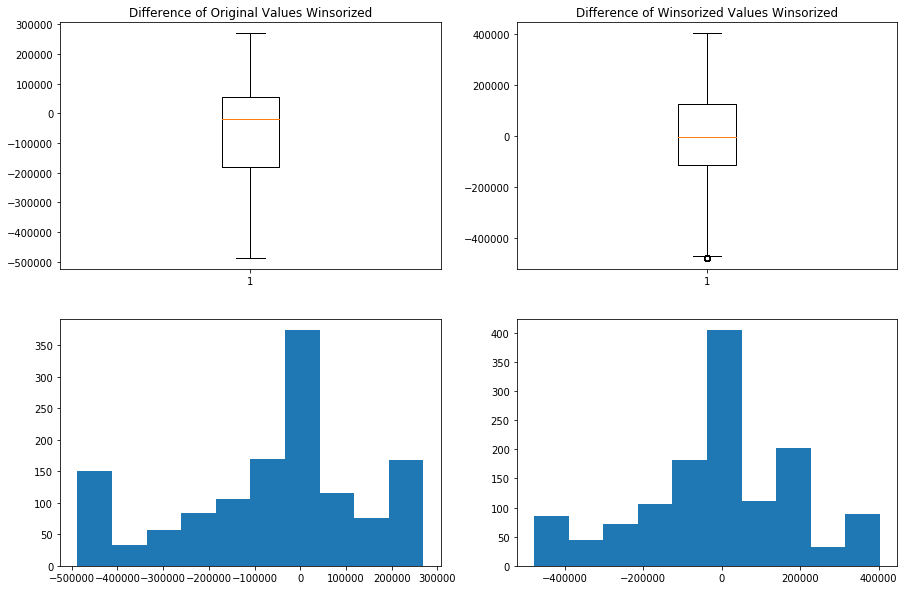

In [31]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(221)
plt.boxplot(wins_def)
plt.title('Difference of Original Values Winsorized')
fig.add_subplot(222)
plt.boxplot(wins_wins_def)
plt.title('Difference of Winsorized Values Winsorized')
fig.add_subplot(223)
plt.hist(wins_def)
fig.add_subplot(224)
plt.hist(wins_wins_def)
plt.show()

- It looks like the differences of the original data tend to be more negative overall - ranging from ~(-500000 to 300000)
- The winsorized then subtracted set is more evenly spread ranging from ~(-500000 to 400000)
- The IQR for the original indicates that the mass majority of values between the 25th and 75th percentile are negative
- Contrary to the IQR for the original the winsorized then subtracted set would imply that the amount of surpluses and deficits are actually very similar in number

In [32]:
len(np.where(wins_def < 0)[0])/len(wins_def)

0.5792637114951165

In [33]:
len(np.where(wins_wins_def < 0)[0])/len(wins_wins_def)

0.5093914350112697

The above displays that the original values clearly have more deficits than surpluses. The double winsorized data is much more even between surpluses and deficits.

### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

I definitely think the method for the 3rd question is superior to the 4th. The reason for this is that it is simply a more accurate representation of the data. Taking the original amounts' difference is just closer to the actual data and will likely produce more accurate results for our ultimate model. I think maintaining as much integrity in the original data as possible is of utmost importance. That, along with the reasoning in question 5, is why I would use the method offered in question 3 over question 4.